1. Time Series Data
2. Deep Neural Networks
3. RNNs - LSTMs
4. Convolutions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras

In [2]:
#Load Data 
data = pd.read_csv('../input/sunspots/Sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
sunspots, labels = [], []
for idx, row in data.iterrows():
    sunspots.append(float(row[2]))
    labels.append(int(row[0]))

In [6]:
series = np.array(sunspots)
time = np.array(labels)

In [8]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

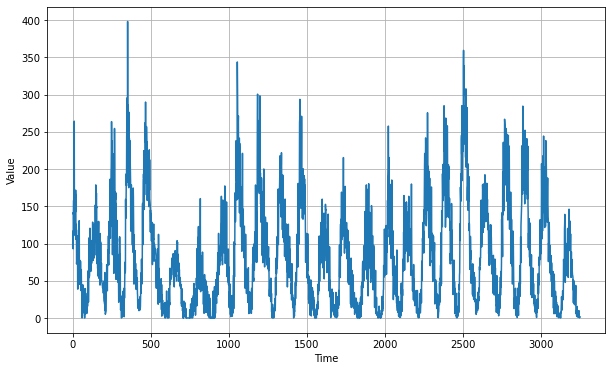

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 216ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 2s 205ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 2s 201ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 2s 206ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 2s 199ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 2s 198ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 2s 196ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 2s 201ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 2s 207ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/

12/12 [==============================] - 3s 218ms/step - loss: 32.8222 - mae: 33.3178
Epoch 83/100
12/12 [==============================] - 3s 211ms/step - loss: 33.9463 - mae: 34.4422
Epoch 84/100
12/12 [==============================] - 2s 202ms/step - loss: 31.0168 - mae: 31.5121
Epoch 85/100
12/12 [==============================] - 3s 216ms/step - loss: 29.9151 - mae: 30.4106
Epoch 86/100
12/12 [==============================] - 2s 200ms/step - loss: 29.1416 - mae: 29.6368
Epoch 87/100
12/12 [==============================] - 2s 200ms/step - loss: 28.2329 - mae: 28.7285
Epoch 88/100
12/12 [==============================] - 2s 202ms/step - loss: 26.8387 - mae: 27.3338
Epoch 89/100
12/12 [==============================] - 2s 203ms/step - loss: 34.1055 - mae: 34.6016
Epoch 90/100
12/12 [==============================] - 2s 200ms/step - loss: 33.5476 - mae: 34.0438
Epoch 91/100
12/12 [==============================] - 2s 200ms/step - loss: 29.2256 - mae: 29.7211
Epoch 92/100
12/12 [===

(1e-08, 0.0001, 0.0, 60.0)

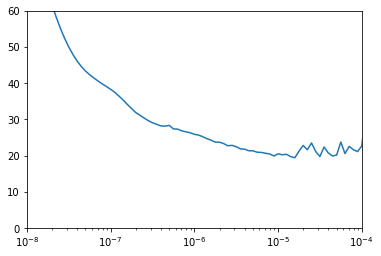

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 101ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 3s 100ms/step - loss: 25.7653 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 3s 99ms/step - loss: 22.0757 - mae: 22.5695
Epoch 4/500
30/30 [==============================] - 3s 104ms/step - loss: 20.4639 - mae: 20.9568
Epoch 5/500
30/30 [==============================] - 3s 103ms/step - loss: 19.7376 - mae: 20.2301
Epoch 6/500
30/30 [==============================] - 3s 104ms/step - loss: 19.3035 - mae: 19.7957
Epoch 7/500
30/30 [==============================] - 3s 99ms/step - loss: 18.7282 - mae: 19.2202
Epoch 8/500
30/30 [==============================] - 3s 103ms/step - loss: 18.1226 - mae: 18.6142
Epoch 9/500
30/30 [==============================] - 3s 101ms/step - loss: 18.0977 - mae: 18.5893
Epoch 10/500
30/30 [==============================] - 3s 101ms/step - loss: 19.7235 - mae: 20.2157
Epoch 11/500
30/30 [=

30/30 [==============================] - 3s 104ms/step - loss: 16.3923 - mae: 16.8809
Epoch 84/500
30/30 [==============================] - 3s 103ms/step - loss: 16.3956 - mae: 16.8843
Epoch 85/500
30/30 [==============================] - 3s 105ms/step - loss: 16.3771 - mae: 16.8660
Epoch 86/500
30/30 [==============================] - 3s 102ms/step - loss: 16.9934 - mae: 17.4824
Epoch 87/500
30/30 [==============================] - 3s 102ms/step - loss: 16.5282 - mae: 17.0168
Epoch 88/500
30/30 [==============================] - 3s 107ms/step - loss: 16.5583 - mae: 17.0478
Epoch 89/500
30/30 [==============================] - 3s 102ms/step - loss: 16.6620 - mae: 17.1509
Epoch 90/500
30/30 [==============================] - 3s 101ms/step - loss: 16.3353 - mae: 16.8236
Epoch 91/500
30/30 [==============================] - 3s 103ms/step - loss: 16.3516 - mae: 16.8401
Epoch 92/500
30/30 [==============================] - 3s 109ms/step - loss: 16.3683 - mae: 16.8569
Epoch 93/500
30/30 [===

30/30 [==============================] - 3s 106ms/step - loss: 16.0940 - mae: 16.5832
Epoch 166/500
30/30 [==============================] - 3s 103ms/step - loss: 15.8946 - mae: 16.3832
Epoch 167/500
30/30 [==============================] - 3s 105ms/step - loss: 15.8555 - mae: 16.3441
Epoch 168/500
30/30 [==============================] - 3s 104ms/step - loss: 15.9548 - mae: 16.4434
Epoch 169/500
30/30 [==============================] - 3s 102ms/step - loss: 15.8370 - mae: 16.3252
Epoch 170/500
30/30 [==============================] - 3s 99ms/step - loss: 15.8086 - mae: 16.2967
Epoch 171/500
30/30 [==============================] - 3s 101ms/step - loss: 15.7432 - mae: 16.2314
Epoch 172/500
30/30 [==============================] - 3s 101ms/step - loss: 15.8847 - mae: 16.3734
Epoch 173/500
30/30 [==============================] - 3s 102ms/step - loss: 15.9121 - mae: 16.4008
Epoch 174/500
30/30 [==============================] - 3s 105ms/step - loss: 15.8590 - mae: 16.3475
Epoch 175/500
3

30/30 [==============================] - 3s 107ms/step - loss: 15.4537 - mae: 15.9411
Epoch 248/500
30/30 [==============================] - 3s 107ms/step - loss: 15.3770 - mae: 15.8644
Epoch 249/500
30/30 [==============================] - 3s 110ms/step - loss: 15.4000 - mae: 15.8874
Epoch 250/500
30/30 [==============================] - 3s 108ms/step - loss: 15.4871 - mae: 15.9748
Epoch 251/500
30/30 [==============================] - 3s 106ms/step - loss: 15.4392 - mae: 15.9264
Epoch 252/500
30/30 [==============================] - 3s 105ms/step - loss: 15.4280 - mae: 15.9154
Epoch 253/500
30/30 [==============================] - 3s 106ms/step - loss: 15.3503 - mae: 15.8373
Epoch 254/500
30/30 [==============================] - 3s 107ms/step - loss: 15.4187 - mae: 15.9062
Epoch 255/500
30/30 [==============================] - 3s 106ms/step - loss: 15.3371 - mae: 15.8243
Epoch 256/500
30/30 [==============================] - 3s 104ms/step - loss: 15.3183 - mae: 15.8053
Epoch 257/500


30/30 [==============================] - 3s 105ms/step - loss: 15.3710 - mae: 15.8587
Epoch 330/500
30/30 [==============================] - 3s 107ms/step - loss: 15.0770 - mae: 15.5638
Epoch 331/500
30/30 [==============================] - 3s 105ms/step - loss: 15.0055 - mae: 15.4922
Epoch 332/500
30/30 [==============================] - 3s 107ms/step - loss: 14.9692 - mae: 15.4551
Epoch 333/500
30/30 [==============================] - 3s 108ms/step - loss: 15.1590 - mae: 15.6461
Epoch 334/500
30/30 [==============================] - 3s 106ms/step - loss: 14.9394 - mae: 15.4254
Epoch 335/500
30/30 [==============================] - 3s 109ms/step - loss: 14.9283 - mae: 15.4143
Epoch 336/500
30/30 [==============================] - 3s 105ms/step - loss: 14.9650 - mae: 15.4513
Epoch 337/500
30/30 [==============================] - 3s 110ms/step - loss: 15.1464 - mae: 15.6332
Epoch 338/500
30/30 [==============================] - 3s 109ms/step - loss: 15.0123 - mae: 15.4982
Epoch 339/500


30/30 [==============================] - 3s 107ms/step - loss: 14.7358 - mae: 15.2216
Epoch 412/500
30/30 [==============================] - 3s 107ms/step - loss: 14.6583 - mae: 15.1440
Epoch 413/500
30/30 [==============================] - 3s 106ms/step - loss: 14.5930 - mae: 15.0786
Epoch 414/500
30/30 [==============================] - 3s 108ms/step - loss: 14.7359 - mae: 15.2218
Epoch 415/500
30/30 [==============================] - 3s 110ms/step - loss: 14.6803 - mae: 15.1660
Epoch 416/500
30/30 [==============================] - 3s 106ms/step - loss: 14.8435 - mae: 15.3299
Epoch 417/500
30/30 [==============================] - 3s 108ms/step - loss: 14.5983 - mae: 15.0836
Epoch 418/500
30/30 [==============================] - 3s 109ms/step - loss: 14.6476 - mae: 15.1333
Epoch 419/500
30/30 [==============================] - 3s 111ms/step - loss: 14.6856 - mae: 15.1716
Epoch 420/500
30/30 [==============================] - 3s 110ms/step - loss: 14.7112 - mae: 15.1972
Epoch 421/500


30/30 [==============================] - 3s 106ms/step - loss: 14.4529 - mae: 14.9388
Epoch 494/500
30/30 [==============================] - 3s 111ms/step - loss: 14.4209 - mae: 14.9065
Epoch 495/500
30/30 [==============================] - 3s 108ms/step - loss: 14.4031 - mae: 14.8889
Epoch 496/500
30/30 [==============================] - 3s 106ms/step - loss: 14.4421 - mae: 14.9281
Epoch 497/500
30/30 [==============================] - 3s 111ms/step - loss: 14.5552 - mae: 15.0410
Epoch 498/500
30/30 [==============================] - 3s 106ms/step - loss: 14.3406 - mae: 14.8264
Epoch 499/500
30/30 [==============================] - 3s 103ms/step - loss: 14.2876 - mae: 14.7727
Epoch 500/500
30/30 [==============================] - 3s 106ms/step - loss: 14.6457 - mae: 15.1323


In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

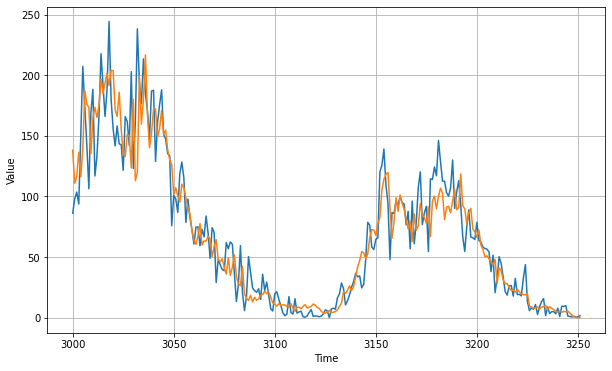

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.516542

<Figure size 432x288 with 0 Axes>

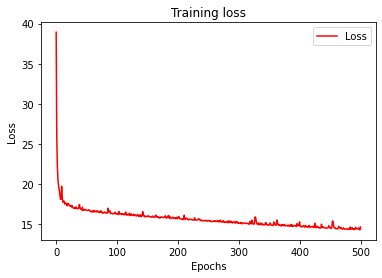

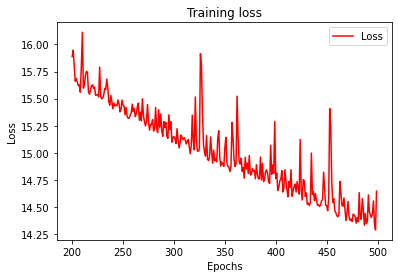

<Figure size 432x288 with 0 Axes>

In [19]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [20]:
print(rnn_forecast)

[ 1.38069397e+02  1.10845924e+02  1.16123222e+02  1.36368912e+02
  1.16104126e+02  1.39681656e+02  1.87099701e+02  1.75868866e+02
  1.73664597e+02  1.35152939e+02  1.64443039e+02  1.73565460e+02
  1.65058685e+02  1.74805161e+02  1.96852066e+02  1.84760635e+02
  1.93643829e+02  2.01447037e+02  1.91431183e+02  2.03917007e+02
  2.03868149e+02  1.71491913e+02  1.65925522e+02  1.86007935e+02
  1.55632858e+02  1.34530518e+02  1.32882263e+02  1.51371094e+02
  1.49831528e+02  1.23419716e+02  1.80071777e+02  1.12921738e+02
  1.19809319e+02  1.99386902e+02  1.59632156e+02  1.79440567e+02
  2.16708328e+02  1.67393875e+02  1.40100510e+02  1.51835770e+02
  1.71940521e+02  1.72152191e+02  1.48926590e+02  1.55734543e+02
  1.71010971e+02  1.51293915e+02  1.54726700e+02  1.38171051e+02
  1.30280563e+02  1.26053238e+02  1.01610733e+02  1.07093880e+02
  1.00372253e+02  9.51761932e+01  1.10049225e+02  1.07158241e+02
  9.87163696e+01  9.09855804e+01  8.53967133e+01  7.25144653e+01
  6.35606346e+01  6.04465